# Título: Visualización de frecuencias fundamental y armónicas de ensayo
## Descripción Ensayo
### Masa: 2
### Fecha de ensayo: 08/02/2020
### Sensor: derecho
### Señal: sensor óptico o inductivo

In [1]:
# Inicialización

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [2]:
# Definiciones de funciones

def fourier_spectrum( nsamples, data, deltat, logdb, power, rms ):
    """Given nsamples of real voltage data spaced deltat seconds apart,
    find the spectrum of the data (its frequency components). If logdb,
    return in dBV, otherwise linear volts. If power, return the power
    spectrum, otherwise the amplitude spectrum. If rms, use RMS volts,
    otherwise use peak-peak volts. Also return the number of frequency
    samples, the frequency sample spacing and maximum frequency. Note:
    The results from this agree pretty much with my HP 3582A FFT
    Spectrum Analyzer,
          although that has higher dynamic range than the 8 bit scope."""
    data_freq = np.fft.rfft(data * np.hanning( nsamples ))
    nfreqs = data_freq.size
    data_freq = data_freq / nfreqs
    ascale = 4
    if( rms ):
        ascale = ascale / ( 2 * np.sqrt(2) )
    if( power ):
        spectrum = ( ascale * absolute(data_freq) )**2
        if( logdb ):
            spectrum = 10.0 * np.log10( spectrum )
    else:
        spectrum = ascale * np.absolute(data_freq)
        if( logdb ):
            spectrum = 20.0 * log10( spectrum )
    freq_step = 1.0 / (deltat * 2 * nfreqs);
    max_freq = nfreqs * freq_step
    return( nfreqs, freq_step, max_freq, spectrum )

## Apertura de archivos de ensayos
Los archivos abiertos corresponden a la configuración de ensayos planificados. Cada uno de ellos corresponden a la siguiente configuración,
* Js11: Banco de sensor inductivo con carga a 1kOhm
* Js12: Banco de sensor inductivo configurado a 2kOhm
* Js13: Banco de sensor inductivo configurado a 4,7kOhm
* Js14: Banco de sensor inductivo configurado a 10kOhm

Cada conjunto de ensayos corresponden a una masa determinada.

Para el caso de este informe se relevan los siguientes archivos,

| Nro ensayo | R configuración | Sensor | Masas elegida | Registro |
|------|------|------|------|------|
|   21  | Js11|   izquierdo  | 2 | Ensayo s_alim 18 CH...|
|   22  | Js12|   izquierdo  | 2 | Ensayo s_alim 19 CH...|
|   23  | Js13|   izquierdo  | 2 | Ensayo s_alim 20 CH...|
|   24  | Js14|   izquierdo  | 2 | Ensayo s_alim 21 CH...|


In [3]:
# Definición de variables de ensayos
fecha = '08/02/2020'
rotor = 'rotor número 2'
sensor = 'izquierdo'
tipo_sensor = 'optico'

In [4]:
# Definición de ruta de archivos de ensayos

ruta_ensayos = 'Registro osciloscopio' + '/'
Js11 = 'Ensayo s_alim 18'
Js12 = 'Ensayo s_alim 20'
Js13 = 'Ensayo s_alim 22'
Js14 = 'Ensayo s_alim 24'
canal_1 = 'CH1'
canal_2 = 'CH2'
extension = '.npz'

ensayo_1_1 = ruta_ensayos + Js11 + ' ' + canal_1 + extension
ensayo_1_2 = ruta_ensayos + Js11 + ' ' + canal_2 + extension
ensayo_2_1 = ruta_ensayos + Js12 + ' ' + canal_1 + extension
ensayo_2_2 = ruta_ensayos + Js12 + ' ' + canal_2 + extension
ensayo_3_1 = ruta_ensayos + Js13 + ' ' + canal_1 + extension
ensayo_3_2 = ruta_ensayos + Js13 + ' ' + canal_2 + extension
ensayo_4_1 = ruta_ensayos + Js14 + ' ' + canal_1 + extension
ensayo_4_2 = ruta_ensayos + Js14 + ' ' + canal_2 + extension

with np.load(ensayo_1_1) as archivo:
    time_V1_1 = archivo['x']
    V1_1 = archivo['y']

with np.load(ensayo_1_2) as archivo:
    time_V1_2 = archivo['x']
    V1_2 = archivo['y']
    
with np.load(ensayo_2_1) as archivo:
    time_V2_1 = archivo['x']
    V2_1 = archivo['y']

with np.load(ensayo_2_2) as archivo:
    time_V2_2 = archivo['x']
    V2_2 = archivo['y']
    
with np.load(ensayo_3_1) as archivo:
    time_V3_1 = archivo['x']
    V3_1 = archivo['y']

with np.load(ensayo_3_2) as archivo:
    time_V3_2 = archivo['x']
    V3_2 = archivo['y']

with np.load(ensayo_4_1) as archivo:
    time_V4_1 = archivo['x']
    V4_1 = archivo['y']

with np.load(ensayo_4_2) as archivo:
    time_V4_2 = archivo['x']
    V4_2 = archivo['y']

## Descripción y elección de canales de medición

Cada ensayo consta de dos mediciones realizadas con el osciloscopio rigol DS1052Z. El canal 1 representa las mediciones relevadas sobre el circuito óptico, el canal 2 representa las tensión medida sobre el sensor inductivo de la balanceadora.

En esta sección se podrá decidir entre una medición y otra.

In [5]:
# Elección entre las dos mediciones 'optica' o 'inductivo'

if (tipo_sensor == 'optico'):
    tiempo_1 = time_V1_1
    tiempo_2 = time_V2_1
    tiempo_3 = time_V3_1
    tiempo_4 = time_V4_1
    V1 = V1_1
    V2 = V2_1
    V3 = V3_1
    V4 = V4_1
elif (tipo_sensor == 'inductivo'):
    tiempo_1 = time_V1_2
    tiempo_2 = time_V2_2
    tiempo_3 = time_V3_2
    tiempo_4 = time_V4_2
    V1 = V1_2
    V2 = V2_2
    V3 = V3_2
    V4 = V4_2

## Recorte de señales medidas
Esta acción se hace necesaria debido a que la adquisición por parte del osciloscopio tiene en sus últimos valores un tramo de datos que no corresponden a la adquisición.

In [6]:
# Recortador de la imagen

ini_cut = np.empty(1)

ini_cut = 0

fin_cut = np.empty(1)

#Definición de cantidad de puntos a recortar desde el final

fin_cut = V1.size - 20

V1_cort = V1[ ini_cut: fin_cut]
tiempo_1_cort = tiempo_1[ ini_cut: fin_cut ]
V2_cort = V2[ ini_cut: fin_cut]
tiempo_2_cort = tiempo_2[ ini_cut: fin_cut ]
V3_cort = V3[ ini_cut: fin_cut]
tiempo_3_cort = tiempo_3[ ini_cut: fin_cut ]
V4_cort = V4[ ini_cut: fin_cut]
tiempo_4_cort = tiempo_4[ ini_cut: fin_cut ]

## Creción de variables para cálculo de transformada de Fourier
El cálculo de fft de cada una de las señales medida requiere variables como cantidad de muestras y el intervalo temporal entre cada muestra.

In [7]:
## Creación de variables para función fourier_spectrum
    # Para V1
nro_muestras_V1 = V1_cort.size
deltat_V1 = tiempo_1_cort[1] - tiempo_1_cort[0]

    #Para V2
nro_muestras_V2 = V2_cort.size
deltat_V2 = tiempo_2_cort[1] - tiempo_2_cort[0]
    
    # Para V3
nro_muestras_V3 = V3_cort.size
deltat_V3 = tiempo_3_cort[1] - tiempo_3_cort[0]

    # Para V4
nro_muestras_V4 = V4_cort.size
deltat_V4 = tiempo_4_cort[1] - tiempo_4_cort[0]

## Cálculo de transformadas

In [8]:
# Cálculo de transformada de fourier para V1
( nfreqs_V1, freq_step_V1, max_freq_V1, spectrum_V1 ) = fourier_spectrum( nro_muestras_V1, V1_cort, deltat_V1, False, False, True )

# Presentación de datos principales en consola del espectro de V1
print ("Freq step", freq_step_V1, "Max freq", max_freq_V1, "Freq bins",nfreqs_V1)

# Cálcula de transformada de fourier para V2
( nfreqs_V2, freq_step_V2, max_freq_V2, spectrum_V2 ) = fourier_spectrum( nro_muestras_V2, V2_cort, deltat_V2, False, False, True )

# Presentación de datos principales en consola del espectro de V2
("Freq step", freq_step_V2, "Max freq", max_freq_V2, "Freq bins", nfreqs_V2)

# Presentación de datos principales en consola del espectro de V1
print ("Freq step", freq_step_V2, "Max freq", max_freq_V2, "Freq bins",nfreqs_V2)


# Cálculo de transformada de fourier para V3
( nfreqs_V3, freq_step_V3, max_freq_V3, spectrum_V3 ) = fourier_spectrum( nro_muestras_V3, V3_cort, deltat_V3, False, False, True )

# Presentación de datos principales en consola del espectro de V1
print ("Freq step", freq_step_V3, "Max freq", max_freq_V3, "Freq bins",nfreqs_V3)

# Cálculo de transformada de fourier para V1
( nfreqs_V4, freq_step_V4, max_freq_V4, spectrum_V4 ) = fourier_spectrum( nro_muestras_V4, V4_cort, deltat_V4, False, False, True )

# Presentación de datos principales en consola del espectro de V1
print ("Freq step", freq_step_V4, "Max freq", max_freq_V4, "Freq bins",nfreqs_V4)


Freq step 0.16707456355033448 Max freq 682.6666666666667 Freq bins 4086
Freq step 0.41768639227847015 Max freq 1706.6665988498291 Freq bins 4086
Freq step 0.41768639227847015 Max freq 1706.6665988498291 Freq bins 4086
Freq step 0.41768639227847015 Max freq 1706.6665988498291 Freq bins 4086


## Creación de gráfico temporal de todos los ensayos

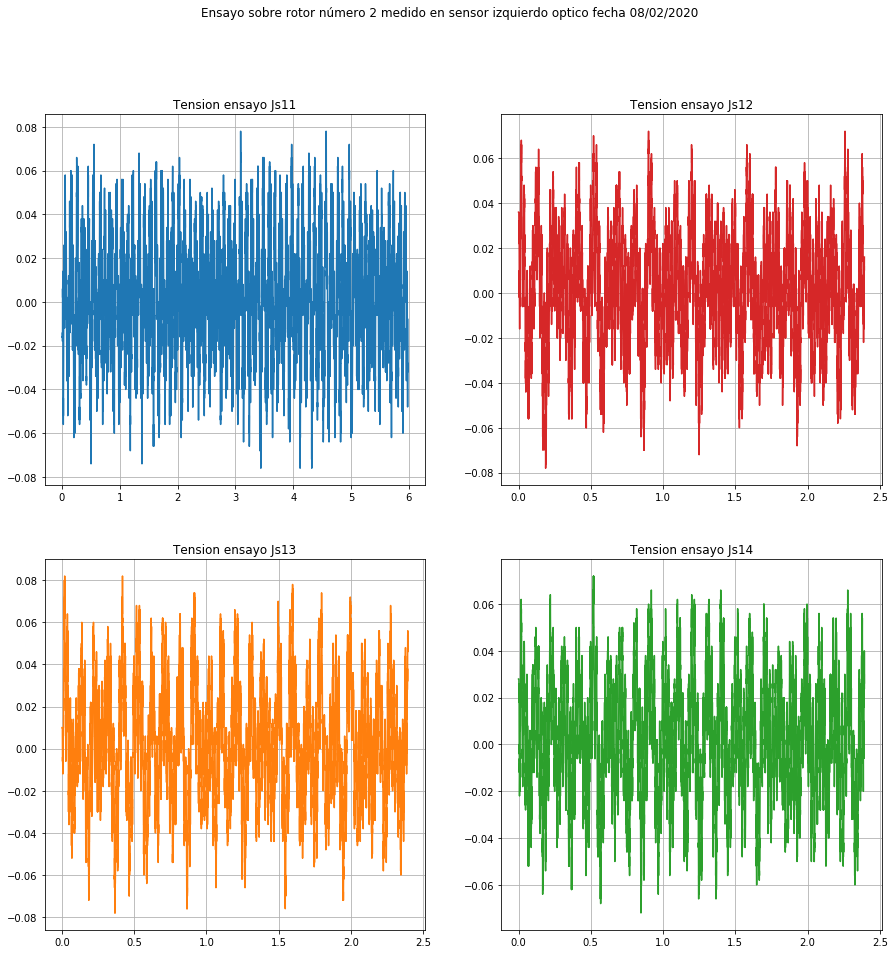

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Ensayo sobre ' + rotor + ' medido en sensor ' + sensor + ' ' + tipo_sensor + ' fecha ' + fecha )
axs[0,0].plot(tiempo_1_cort, V1_cort)
axs[0,0].set_title('Tension ensayo Js11')
axs[0,0].grid(True)
#axs[0,1].set_xlim( 0, 100 )
axs[0,1].plot( tiempo_2_cort, V2_cort, 'tab:red')
axs[0,1].set_title('Tension ensayo Js12')
axs[0,1].grid(True)
axs[1,0].plot(tiempo_3_cort, V3_cort, 'tab:orange')
axs[1,0].set_title('Tension ensayo Js13')
axs[1,0].grid(True)
#axs[1,1].set_xlim( 0, 100 )
axs[1,1].plot( tiempo_4_cort, V4_cort, 'tab:green')
axs[1,1].set_title('Tension ensayo Js14')
axs[1,1].grid(True)

## Creación de gráfico de espectro de mediciones y representación de picos

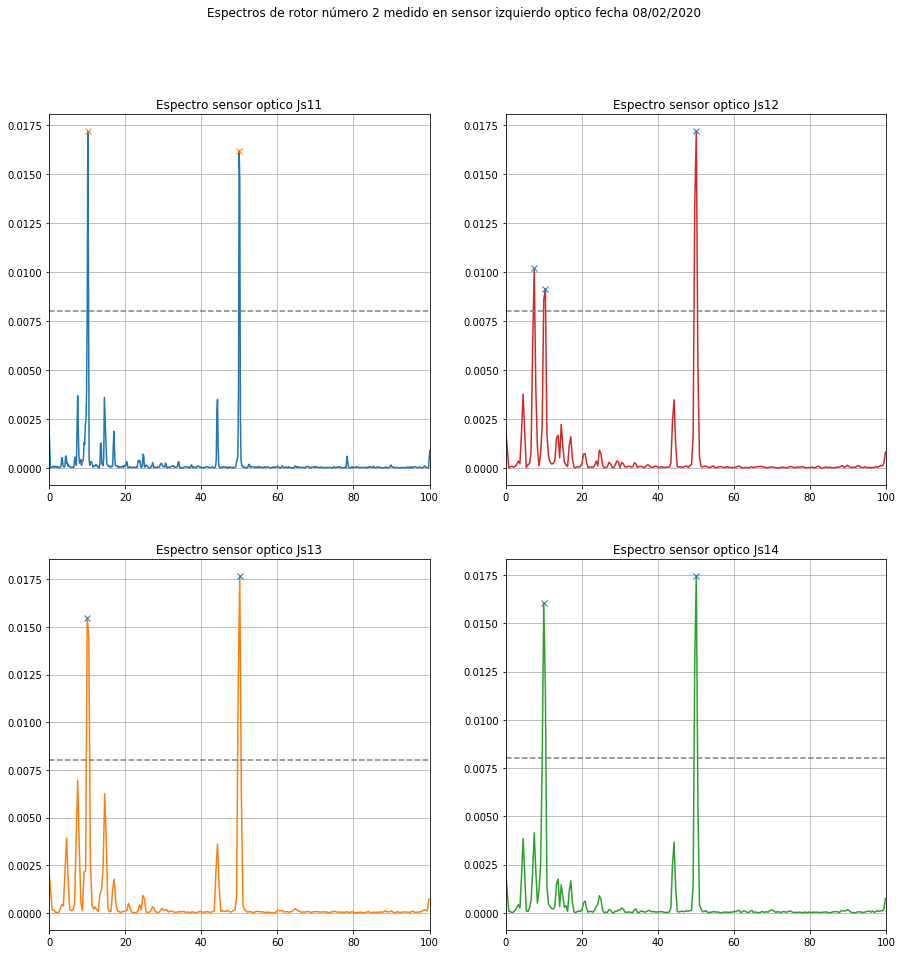

In [10]:
# Creción de eje de frecuencias para cada gráfico de espectro
freqs_V1 = np.arange( 0, max_freq_V1, freq_step_V1 )
freqs_V2 = np.arange( 0, max_freq_V2, freq_step_V2 )
freqs_V3 = np.arange( 0, max_freq_V3, freq_step_V3 )
freqs_V4 = np.arange( 0, max_freq_V4, freq_step_V4 )

# Acondicionamiento de vector de frecuencias creado para evitar problemas si la cantidad de puntos es par o impar
freqs_V1 = freqs_V1[0:spectrum_V1.size]
freqs_V2 = freqs_V2[0:spectrum_V2.size]
freqs_V3 = freqs_V3[0:spectrum_V3.size]
freqs_V4 = freqs_V4[0:spectrum_V4.size]

# Búsque da picos en espectro con su umbral
umbral = 0.008
picos_V1, _ = find_peaks(spectrum_V1, height=umbral)
picos_V2, _ = find_peaks(spectrum_V2, height=umbral)
picos_V3, _ = find_peaks(spectrum_V3, height=umbral)
picos_V4, _ = find_peaks(spectrum_V4, height=umbral)

# Representación en subplot de gráficos como vienen e invertidos

fig, axs = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Espectros de ' + rotor + ' medido en sensor ' + sensor + ' ' + tipo_sensor + ' fecha ' + fecha )
axs[0,0].set_xlim( 0, 100 )
axs[0,0].plot(freqs_V1, spectrum_V1)
axs[0,0].plot(freqs_V1[picos_V1], spectrum_V1[picos_V1], "x")
axs[0,0].plot(np.ones(spectrum_V1.size)*umbral, "--", color="gray")
axs[0,0].set_title('Espectro sensor ' + tipo_sensor + ' Js11')
axs[0,0].grid(True)

axs[0,1].set_xlim( 0, 100 )
axs[0,1].plot( freqs_V2, spectrum_V2, 'tab:red')
axs[0,1].plot(freqs_V2[picos_V2], spectrum_V2[picos_V2], "x")
axs[0,1].plot(np.ones(spectrum_V2.size)*umbral, "--", color="gray")
axs[0,1].set_title('Espectro sensor ' + tipo_sensor + ' Js12')
axs[0,1].grid(True)

axs[1,0].set_xlim( 0, 100 )
axs[1,0].plot(freqs_V3, spectrum_V3, 'tab:orange')
axs[1,0].plot(freqs_V3[picos_V3], spectrum_V3[picos_V3], "x")
axs[1,0].plot(np.ones(spectrum_V3.size)*umbral, "--", color="gray")
axs[1,0].set_title('Espectro sensor ' + tipo_sensor + ' Js13')
axs[1,0].grid(True)

axs[1,1].set_xlim( 0, 100 )
axs[1,1].plot( freqs_V4, spectrum_V4, 'tab:green')
axs[1,1].plot(freqs_V4[picos_V4], spectrum_V4[picos_V4], "x")
axs[1,1].plot(np.ones(spectrum_V4.size)*umbral, "--", color="gray")
axs[1,1].set_title('Espectro sensor ' + tipo_sensor + ' Js14')
axs[1,1].grid(True)


## Comparación de picos de fundamental y armónicos
Comparación de cada uno de los picos en frecuencia y rms

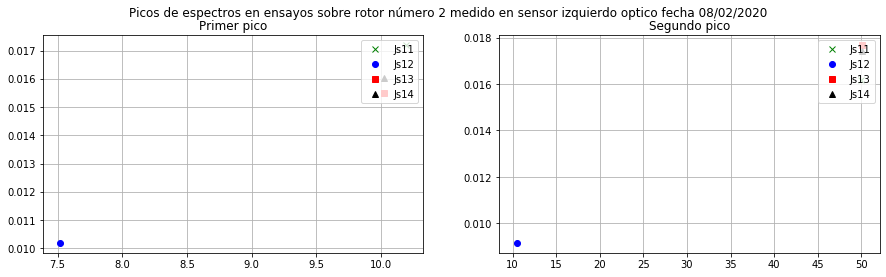

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15,4))
fig.suptitle('Picos de espectros en ensayos sobre ' + rotor + ' medido en sensor ' + sensor + ' ' + tipo_sensor + ' fecha ' + fecha )
axs[0].plot(freqs_V1[picos_V1[0]], spectrum_V1[picos_V1[0]], "x", color = "green", label = 'Js11')
axs[0].plot(freqs_V2[picos_V2[0]], spectrum_V2[picos_V2[0]], "o", color = "blue", label = 'Js12')
axs[0].plot(freqs_V3[picos_V3[0]], spectrum_V3[picos_V3[0]], "s", color = "red", label = 'Js13')
axs[0].plot(freqs_V4[picos_V4[0]], spectrum_V4[picos_V4[0]], "^", color = "black", label = 'Js14')
axs[0].set_title('Primer pico')
axs[0].grid(True)
axs[0].legend(loc="upper right")

axs[1].plot(freqs_V1[picos_V1[1]], spectrum_V1[picos_V1[1]], "x", color = "green", label = 'Js11')
axs[1].plot(freqs_V2[picos_V2[1]], spectrum_V2[picos_V2[1]], "o", color = "blue", label = 'Js12')
axs[1].plot(freqs_V3[picos_V3[1]], spectrum_V3[picos_V3[1]], "s", color = "red", label = 'Js13')
axs[1].plot(freqs_V4[picos_V4[1]], spectrum_V4[picos_V4[1]], "^", color = "black", label = 'Js14')
axs[1].set_title('Segundo pico')
axs[1].grid(True)
axs[1].legend(loc="upper right")


## Valores de picos

In [12]:
print('Frecuencia 1er pico Js11', np.around(freqs_V1[picos_V1[0]], decimals = 3), '\nAmplitud 1er pico Js11', np.around(spectrum_V1[picos_V1[0]], decimals = 4 ), '\n')
print('Frecuencia 2do pico Js11', np.around(freqs_V1[picos_V1[1]], decimals = 3), '\nAmplitud 2do pico Js11', np.around(spectrum_V1[picos_V1[1]], decimals = 4 ), '\n')
#print('Frecuencia 3er pico Js11', np.around(freqs_V1[picos_V1[2]], decimals = 3), '\nAmplitud 3er pico Js11', np.around(spectrum_V1[picos_V1[2]], decimals = 4 ), '\n')

print('Frecuencia 1er pico Js12', np.around(freqs_V2[picos_V2[0]], decimals = 3), '\nAmplitud 1er pico Js12', np.around(spectrum_V2[picos_V2[0]], decimals = 4 ), '\n')
print('Frecuencia 2do pico Js12', np.around(freqs_V2[picos_V2[1]], decimals = 3), '\nAmplitud 2do pico Js12', np.around(spectrum_V2[picos_V2[1]], decimals = 4 ), '\n')
#print('Frecuencia 3er pico Js12', np.around(freqs_V2[picos_V2[2]], decimals = 3), '\nAmplitud 3er pico Js12', np.around(spectrum_V2[picos_V2[2]], decimals = 4 ), '\n')

print('Frecuencia 1er pico Js13', np.around(freqs_V3[picos_V3[0]], decimals = 3), '\nAmplitud 1er pico Js13', np.around(spectrum_V3[picos_V3[0]], decimals = 4 ), '\n')
print('Frecuencia 2do pico Js13', np.around(freqs_V3[picos_V3[1]], decimals = 3), '\nAmplitud 2do pico Js13', np.around(spectrum_V3[picos_V3[1]], decimals = 4 ), '\n')
#print('Frecuencia 3er pico Js13', np.around(freqs_V3[picos_V3[2]], decimals = 3), '\nAmplitud 3er pico Js13', np.around(spectrum_V3[picos_V3[2]], decimals = 4 ), '\n')

print('Frecuencia 1er pico Js14', np.around(freqs_V4[picos_V4[0]], decimals = 3), '\nAmplitud 1er pico Js14', np.around(spectrum_V4[picos_V4[0]], decimals = 4 ), '\n')
print('Frecuencia 2do pico Js14', np.around(freqs_V4[picos_V4[1]], decimals = 3), '\nAmplitud 2do pico Js14', np.around(spectrum_V4[picos_V4[1]], decimals = 4 ), '\n')
#print('Frecuencia 3er pico Js14', np.around(freqs_V4[picos_V4[2]], decimals = 3), '\nAmplitud 3er pico Js14', np.around(spectrum_V4[picos_V4[2]], decimals = 4 ), '\n')

Frecuencia 1er pico Js11 10.192 
Amplitud 1er pico Js11 0.0172 

Frecuencia 2do pico Js11 49.955 
Amplitud 2do pico Js11 0.0162 

Frecuencia 1er pico Js12 7.518 
Amplitud 1er pico Js12 0.0102 

Frecuencia 2do pico Js12 10.442 
Amplitud 2do pico Js12 0.0092 

Frecuencia 1er pico Js13 10.024 
Amplitud 1er pico Js13 0.0155 

Frecuencia 2do pico Js13 50.122 
Amplitud 2do pico Js13 0.0177 

Frecuencia 1er pico Js14 10.024 
Amplitud 1er pico Js14 0.016 

Frecuencia 2do pico Js14 50.122 
Amplitud 2do pico Js14 0.0174 

